## Code with constant and stochastic hurst exponent simulations

In [1]:
import numpy as np
import tensorflow as tf
from stochastic.processes.continuous import FractionalBrownianMotion
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
import math
import pandas as pd
%matplotlib notebook
import scipy.stats as stats

pi = math.pi

In [2]:
def gen_fbm_track(ntimes, hurst_exp, initial_position=[0,0,0]):
    """
    Function to produce single fbm track, with normalisation
    """

    fbm = FractionalBrownianMotion(hurst=hurst_exp,t=1,rng=None)
    x = fbm.sample(ntimes)
    y = fbm.sample(ntimes)
    z = fbm.sample(ntimes)
    
    #r = np.sqrt((np.amax(x)-np.amin(x))**2 + (np.amax(y)-np.amin(y))**2 + (np.amax(z)-np.amin(z))**2) 
    
    dx = (x[1:]-x[0:-1])/(np.amax(x)-np.amin(x))#r
    dy = (y[1:]-y[0:-1])/(np.amax(y)-np.amin(y))#r
    dz = (z[1:]-z[0:-1])/(np.amax(z)-np.amin(z))#r
    
    #dx = (x[1:]-x[0:-1])*hurst_exp
    #dy = (y[1:]-y[0:-1])*hurst_exp
    #dz = (z[1:]-z[0:-1])*hurst_exp
    
    x_norm = np.append(np.array([0]),np.cumsum(dx))
    y_norm = np.append(np.array([0]),np.cumsum(dy))
    z_norm = np.append(np.array([0]),np.cumsum(dz))

    x0, y0, z0 = initial_position
    #x, y, z = x+x0,y+y0,z+z0#
    x, y, z = x_norm+x0, y_norm+y0, z_norm+z0
        
    return x[:ntimes], y[:ntimes], z[:ntimes]

def get_exit_index(xs, ys, radius):
    #input entire track
    i = 0
    index = None
    
    while i<len(xs):
        if xs[i]**2 + ys[i]**2 > radius**2:
            index = i
            break 
        i+=1 
        
    return index

def track_until_collision(xs, ys, zs, radius, exit_index):
    """
    Function to restrict an initial track, based on cylindrical geometry
    returns shortened track
    """
    #input entire track

    xs = xs[:exit_index]
    ys = ys[:exit_index]
    zs = zs[:exit_index]
    return xs, ys, zs


def split_track_at_collision(xs, ys, zs, radius, exit_index):
    """
    Function to split track into pre and post collision segments
    """
    #input entire track
    i = exit_index
    xs_before = xs[:i]
    ys_before = ys[:i]
    zs_before = zs[:i]
    xs_after = xs[i:]
    ys_after = ys[i:]
    zs_after = zs[i:]
    return (xs_before, ys_before, zs_before), (xs_after, ys_after, zs_after)

def exit_check(xs, ys, radius, exit_index):
    #input entire track
    if exit_index==None:
        exit_info = 'no exit'
    else: 
        exit_info = 'exit'
        
    return exit_info

def get_exit_step(xs, ys, zs, radius, exit_index):
    #input entire track
    i = exit_index
    dx = xs[i+1]-xs[i]
    dy = ys[i+1]-ys[i]
    dz = zs[i+1]-zs[i]
    return dx, dy, dz

def get_exit_vector(xs_exit, ys_exit, zs_exit, r):
    
    dx = xs_exit[1]-xs_exit[0]
    dy = ys_exit[1]-ys_exit[0]
    dz = zs_exit[1]-zs_exit[0]
    return dx, dy, dz

def get_exit_coords(xs, ys, zs, radius, exit_index):
    """
    Function to return coordinates that exceed boundary
    """
    #input entire track
    i = exit_index
    xs_exit = xs[i-1:i+1]
    ys_exit = ys[i-1:i+1]
    zs_exit = zs[i-1:i+1]
    return xs_exit, ys_exit, zs_exit

def get_intersection_point(xs_exit, ys_exit, zs_exit, r):
    
    x1,x2 = xs_exit
    y1,y2 = ys_exit
    z1,z2 = zs_exit
    
    dx, dy, dz = get_exit_vector(xs_exit, ys_exit, zs_exit, r)
    
    #parameterize to get quadratic in t, at^2+bt+c=0
    a = dx**2 + dy**2
    b = 2*x1*dx + 2*y1*dy
    c = x1**2 + y1**2 - r**2
    
    #solve to get two roots
    t_roots = np.roots([a,b,c])
    x_roots = x1 + t_roots*dx
    y_roots = y1 + t_roots*dy
    z_roots = z1 + t_roots*dz
    
    #choose root that corresponds to the exit point
    i = np.argmin((x2-x_roots)**2+(y2-y_roots)**2)
    
    return x_roots[i], y_roots[i], z_roots[i]

def get_mod(v):
    
    return np.sqrt(np.dot(v,v))

def get_exit_angle(xs_exit, ys_exit, zs_exit, r):
    
    x_intersection, y_intersection = get_intersection_point(xs_exit, ys_exit, zs_exit, r)[:2]
    r_vector = np.array([x_intersection, y_intersection])
    exit_vector = get_exit_vector(xs_exit, ys_exit, zs_exit, r)[:2]  #taking only first two elements, ignoring z
    
    rmod = get_mod(r_vector)
    exit_mod = get_mod(exit_vector)
    
    cos_theta = np.dot(r_vector,exit_vector)/(rmod*exit_mod)
    
    return np.arccos(cos_theta)

def get_acw_rotation_angle(xs_exit, ys_exit, zs_exit, r):

    x_intersection, y_intersection = get_intersection_point(xs_exit, ys_exit, zs_exit, r)[:2]
    r_vector = np.array([x_intersection, y_intersection])
    exit_vector = get_exit_vector(xs_exit, ys_exit, zs_exit, r)[:2]  #taking only first two elements, ignoring z
    
    theta = get_exit_angle(xs_exit, ys_exit, zs_exit, r)
    rot_angle = np.pi-2*theta
    if np.cross(r_vector, exit_vector) > 0:
        return rot_angle
    else:
        return -rot_angle

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)
    return qx, qy

def gen_fbm_track_with_reflection(hurst_exp, radius, ntimes, initial_pos=(0,0,0)):
    
    #generate entire track
    data_x, data_y, data_z = gen_fbm_track(ntimes, hurst_exp, initial_pos)
    
    #keep going if track exits cylinder
    #keep_going = exit_check(data_x, data_y, radius)
    collision_points = np.array([0,0,0])
    collision_counter = 0
    #while exit_check(data_x, data_y, radius)=='exit':
    while exit_check(data_x, data_y, radius)=='exit' and collision_counter<ntimes:
        
        xs_exit, ys_exit, zs_exit = get_exit_coords(data_x, data_y, data_z, radius)
        collision_xyz = get_intersection_point(xs_exit, ys_exit, zs_exit, radius)
        collision_points = np.vstack((collision_points, collision_xyz))
        x_coll, y_coll, z_coll = collision_xyz
        collision_counter += 1
        #print('Collision counter: {}'.format(collision_counter))
        print(collision_xyz)
        
        acw_rot_angle = get_acw_rotation_angle(xs_exit, ys_exit, zs_exit, radius)
        
        (xs_before, ys_before, zs_before), (xs_after, ys_after, zs_after) = split_track_at_collision(data_x, data_y, data_z,
                                                                                                     radius)
        xs_after_rot, ys_after_rot = rotate([x_coll, y_coll], [xs_after, ys_after], acw_rot_angle)
        
        data_x = np.concatenate((xs_before, x_coll, xs_after_rot), axis=None)
        data_y = np.concatenate((ys_before, y_coll, ys_after_rot), axis=None)
        data_z = np.concatenate((zs_before, z_coll, zs_after), axis=None)  # z unchanged
        
        #keep_going = exit_check(data_x, data_y, radius)
        
    if collision_counter==ntimes:
        result_quality = 'bad'
    else:
        result_quality = 'good'
        
    return data_x, data_y, data_z, collision_points[1:], result_quality
    
def gen_fbm_track_new_const_h(radius, ntimes, hurst_exp=None, initial_pos=(0,0,0)):
    
    if hurst_exp == None:
        hurst_exp = np.random.uniform(0.001,0.999)
    
    data_x, data_y, data_z = gen_fbm_track(ntimes, hurst_exp, initial_pos)
    exit_index = get_exit_index(data_x, data_y, radius)
    
    initial_pos_array = initial_pos
    collision_counter = 0

    if exit_index != None:
        
        collision_counter += 1
    
        xs_exit, ys_exit, zs_exit = get_exit_coords(data_x, data_y, data_z, radius, exit_index)
        collision_xyz = get_intersection_point(xs_exit, ys_exit, zs_exit, radius)
        collision_points = collision_xyz

        data_x, data_y, data_z = track_until_collision(data_x, data_y, data_z, radius, exit_index)
        coll_indices = np.array([len(data_x)])

        while len(data_x) < ntimes:

            new_initial_pos = collision_xyz
            x, y, z = gen_fbm_track(ntimes+1, hurst_exp, initial_position=new_initial_pos)

            #remove collision point for now, will add back in later
            x, y, z = x[1:], y[1:], z[1:]

            new_x = np.append(data_x, x)
            new_y = np.append(data_y, y)
            new_z = np.append(data_z, z)

            new_exit_index = get_exit_index(new_x, new_y, radius)
            
            if new_exit_index == None:
                data_x,data_y,data_z = new_x, new_y, new_z
                
            else:
                new_data_x, new_data_y, new_data_z = track_until_collision(new_x, new_y, new_z, radius, new_exit_index)

                #to avoid duplicates in initial_pos_array
                if new_data_x[-1]!=data_x[-1]:
                    
                    initial_pos_array = np.vstack((initial_pos_array, new_initial_pos))
                    data_x, data_y, data_z = new_data_x, new_data_y, new_data_z
                    
                    xs_exit, ys_exit, zs_exit = get_exit_coords(new_x, new_y, new_z, radius, new_exit_index)
                    collision_xyz = get_intersection_point(xs_exit, ys_exit, zs_exit, radius)
                    collision_points = np.vstack((collision_points, collision_xyz))
                    coll_indices = np.append(coll_indices, len(data_x))
                    collision_counter +=1

    #insert collision points
    if collision_counter > 0:
        coll_xs, coll_ys, coll_zs = np.transpose(collision_points)
        data_x = np.insert(data_x, coll_indices, coll_xs)
        data_y = np.insert(data_y, coll_indices, coll_ys)
        data_z = np.insert(data_z, coll_indices, coll_zs)
    
    data_x, data_y, data_z = data_x[:ntimes], data_y[:ntimes], data_z[:ntimes]
    
    if collision_counter > 0:
        if collision_counter ==1:
            coll_xs,coll_ys,coll_zs = np.array([coll_xs]),np.array([coll_ys]),np.array([coll_zs])
        coll_xs = coll_xs[np.where(np.isin(coll_xs, data_x))]
        coll_ys = coll_ys[np.where(np.isin(coll_ys, data_y))]
        coll_zs = coll_zs[np.where(np.isin(coll_zs, data_z))]
        coll_pts = np.transpose(np.concatenate(([coll_xs], [coll_ys], [coll_zs]), axis=0))
        initial_pos_array = np.vstack((initial_pos,coll_pts))
    
    return data_x, data_y, data_z, initial_pos_array, hurst_exp
    

In [3]:
def plot_random_walk_single(axis, data_x, data_y, data_z, init_pos=[0,0,0],c_line='k',cmap_line=None):
    """
    Function to plot one random walk, has color arguments for different h values in stoch model
    """
    
    if cmap_line == None:
        axis.plot(data_x, data_y, data_z,color=c_line)
    else:
        axis.plot(data_x, data_y, data_z,color=c_line,cmap=cmap_line)
        
    axis.scatter(data_x[0], data_y[0], data_z[0], color='green')
    axis.scatter(data_x[-1], data_y[-1], data_z[-1], color='red')

In [4]:
def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    """
    Function to generate data required for plotting the cylinder
    """
    z = np.linspace(-height_z/2, height_z/2, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

def plot_cylinder_along_z(axis, center_x, center_y, radius, height_z):
    """
    Function to plot cylinder in 3d plot
    """
    Xc,Yc,Zc = data_for_cylinder_along_z(center_x, center_y, radius, height_z)
    axis.plot_surface(Xc, Yc, Zc, alpha=0.1)
    axis.set_xlabel('x')
    axis.set_ylabel('y')
    axis.set_zlabel('z')
    axis.set_xlim(-1.5*radius, 1.5*radius)
    axis.set_ylim(-1.5*radius, 1.5*radius)

In [5]:
def plot_random_walks(axis, data_x, data_y, data_z):
    for i in range(len(data_x)):  # plotting each track
        axis.plot(data_x[i,:],data_y[i,:],data_z[i,:])
        
def get_rand_initial_pos_2(radius,z_lim=None):
    """
    Function to generate randomised initial position, within cylinder
    """    
    r = radius*np.sqrt(np.random.random())
    theta = np.random.random()*2*pi
    
    x0 = r*np.cos(theta)
    y0 = r*np.sin(theta)
    
    if z_lim==None:
        z_lim = radius
    z0 = np.random.uniform(-z_lim, z_lim, 1)[0]
    
    return (x0,y0,z0)

In [6]:
def plot_in_cylinder(r,nsteps,h = None,initial_pos=(0,0,0)):
    """
    Function to plot fbm random walk in cylindrical geometry
    """
    
    data_x, data_y, data_z, col_pos_array,h_val = gen_fbm_track_new_const_h(r, nsteps,initial_pos=initial_pos)

    fig = plt.figure()
    ax = Axes3D(fig)
    
    plot_random_walk_single(ax, data_x, data_y, data_z)
    plot_cylinder_along_z(ax,0, 0, r, 2*np.max(np.abs(data_z)))
    try:
        ax.scatter(xs=col_pos_array[:,0], ys=col_pos_array[:,1], zs=col_pos_array[:,2], color='orange')
    except :IndexError
    
    plt.suptitle("Fractional Brownian Motion In Cylinder \n Hurst Exponent = {:f}; Radius = {}".format(h_val,r))

def plot_in_cylinder_refl(h, r, ntimes, include_reflection=False, initial_pos=(0,0,0)):
    
    if include_reflection:
        result_quality = 'bad'
        run_counter = 0
        while result_quality=='bad':
            data_x, data_y, data_z, coll_pts, result_quality = gen_fbm_track_with_reflection(h, r, ntimes, initial_pos=initial_pos)
            run_counter += 1
            print('Run counter: ', run_counter)
    else:
        data_x, data_y, data_z, coll_pts = gen_fbm_track_new(h, r, ntimes, initial_pos=initial_pos)
    print('Number of collisions: {}'.format(len(coll_pts)))
    print(coll_pts)
    
    fig = plt.figure()
    ax = Axes3D(fig)
    #ax = fig.add_subplot(projection="3d")
    
    plot_random_walk_single(ax, data_x, data_y, data_z)
    plot_cylinder_along_z(ax, 0, 0, r, 2*np.max(np.abs(data_z)))
    try:
        ax.scatter(xs=coll_pts[:,0], ys=coll_pts[:,1], zs=coll_pts[:,2], color='r')
    except: IndexError

In [23]:
def gen_mc_fbm_cylinder_data(radius, track_length, mc_samples,model_type,h_noise_amp=0.1):
    """
    Function to generate panda dataframe from many monte carlo repeats of 
    fbm in pipe simulation. Track length is always equal, of size track_length, 
    with number of mc repeats = mc_samples. Model type specifies whether to use
    the same hurst after collisions, a stochastic one or a constant one with 
    classical reflection.
    Model types: 'const_h', 'stoch_h', 'const_h_refl'
    h_noise_amp: amplitude of noise term for stoch_h model
    """
    
    xyz_step_track_time_arr = np.empty((mc_samples*track_length, 7))

    for i in np.arange(mc_samples):
    
        track_id_arr = np.full((track_length,1),i)
        timestep_arr = np.arange(track_length)
        timestep_arr = np.reshape(timestep_arr,(track_length,1))
        timeabs_arr = 17.6*timestep_arr
        
        initial_position = get_rand_initial_pos_2(radius)

        if model_type=="const_h":
            x,y,z,_,h_val = gen_fbm_track_new_const_h(radius, track_length,hurst_exp = None,
                                                      initial_pos=initial_position)
            h_arr = np.full((track_length,1),h_val)
        elif model_type=="stoch_h":
            x,y,z,_,h_arr =gen_fbm_track_new_stoch_h(radius, track_length, h_noise_amp, lower_h_lim = 0.001,
                                                            upper_h_lim = 0.999, initial_pos=initial_position)
            h_arr = np.reshape(h_arr,(track_length,1))
    
        x = np.reshape(x,(track_length,1))
        y = np.reshape(y,(track_length,1))
        z = np.reshape(z,(track_length,1))
        
        xyz_step_track_time_arr[i*track_length:(i+1)*track_length,:] = np.hstack((x,y,z,timestep_arr,
                                                                                  track_id_arr,timeabs_arr,h_arr))
    
    header_arr = ["Position X","Position Y","Position Z","Time","TrackID","Absolute Time","Simulated Hurst"]
 
    xyz_step_track_time_df = pd.DataFrame(xyz_step_track_time_arr, columns = header_arr)
    
    return xyz_step_track_time_df

def save_to_csv(track_df,radius,track_length,mc_samples,model_type,h_noise_amp=None,folder_path=None):
    """
    Function to save panda dataframe from mc simulation
    Model types: 'const_h', 'stoch_h', 'const_h_refl'
    h_noise_amp: amplitude of noise term for stoch_h model
    """
    if model_type == "const_h":
        filename = "{}_r{:.1f}_l{}_mc{}_cylinder_data.csv".format(model_type,radius,
                                                              track_length,mc_samples)
    elif model_type == "stoch_h":
        filename = "{}_hna{:.1f}_r{:.1f}_l{}_mc{}_cylinder_data.csv".format(model_type,h_noise_amp,radius,
                                                              track_length,mc_samples)
        
    if folder_path!=None:
        filename = folder_path + filename
        
    track_df.to_csv(filename,index=False)
    
def gen_mc_fbm_cylinder_csv(radius,track_length,mc_samples,model_type,h_noise_amplitude=0.1,folder_path=None):
    """
    Function to generate and save mc data, fbm in pipe
    Model types: 'const_h', 'stoch_h', 'const_h_refl'
    h_noise_amp: amplitude of noise term for stoch_h model
    
    """
    xyz_step_track_time_df = gen_mc_fbm_cylinder_data(radius,track_length,mc_samples,
                                                      model_type,h_noise_amp=h_noise_amplitude)
    
    save_to_csv(xyz_step_track_time_df,radius,track_length,mc_samples,
                model_type,h_noise_amp=h_noise_amplitude,folder_path=folder_path)
    
    return xyz_step_track_time_df
    

## Stochastic Hurst Exponent

In [24]:
def crawling_h_uniform_dist(length, amplitude, abs_lower_lim, abs_upper_lim):
    """
    Function to generate array of h exponent values, using stochastic method
    hurst value updates iteratively based on previously value, with new sample
    generated from a uniform distribution centred on the previously value
    - when the previous value is near the limits, the uniform distrivution shifts 
    away from the limit
    amplitude: noise amplitude ( how large is the uniform distribution)
    abs____lim: upper and lower limits to be bound by, 0 and 1 for hurst
    """
    h_arr = np.empty(length)
    h0 = np.random.uniform(abs_lower_lim,abs_upper_lim)
    h_arr[0] = h0
    
    for i in np.arange(length-1):
        
        lower_lim,upper_lim = gen_lims(h_arr[i],amplitude,abs_lower_lim,abs_upper_lim)

        h_arr[i+1] = np.random.uniform(lower_lim,upper_lim)
    
    return h_arr

def crawling_h_gauss_dist(length, amplitude, abs_lower_lim, abs_upper_lim):
    """
    Function to generate array of h exponent values, using stochastic method
    hurst value updates iteratively based on previously value, with new sample
    generated from a uniform distribution centred on the previously value
    - when the previous value is near the limits, the uniform distrivution shifts 
    away from the limit
    amplitude: noise amplitude ( how large is the uniform distribution)
    abs____lim: upper and lower limits to be bound by, 0 and 1 for hurst
    """
    h_arr = np.empty(length)
    h0 = stats.truncnorm.rvs(abs_lower_lim, abs_upper_lim)
    h_arr[0] = h0
    
    for i in np.arange(length-1):
        
        lower_lim,upper_lim = gen_lims(h_arr[i],amplitude,abs_lower_lim,abs_upper_lim)

        h_arr[i+1] = stats.truncnorm.rvs(lower_lim, upper_lim)
    
    return h_arr

def gen_lims(centre,amplitude,absolute_lower_lim,absolute_upper_lim):
    """
    Function to generate limits of uniform distribution to sample from for next 
    hurst value, in 'crawling_h_uniform_dist'. Shifts range of uniform distribution 4
    in opposite direction, and equal to amount the distribution oversteps by.
    centre: previous hurst value
    """
    #temporary values of new limits, symetrically centred on previous value
    temp_ll = centre - amplitude/2
    temp_ul = centre + amplitude/2
    
    if temp_ll < absolute_lower_lim:
        #if temp. lower lim is less than abs. lower lim, reset
        # and increase upper lim by lower limit overstep
        ll = absolute_lower_lim
        ul = temp_ul + abs(temp_ll-absolute_lower_lim)
    
    elif temp_ul > absolute_upper_lim:
        #if temp. upper lim is more than abs. upper lim, reset
        # and decrease lower lim by upper limit overstep
        ll = temp_ll - abs(temp_ul-absolute_upper_lim)
        ul = absolute_upper_lim
        
    else:
        ll = temp_ll
        ul = temp_ul
        
    return ll,ul
    
stoch_h = crawling_h_gauss_dist(100,0.2,0.001,0.999)  

<IPython.core.display.Javascript object>


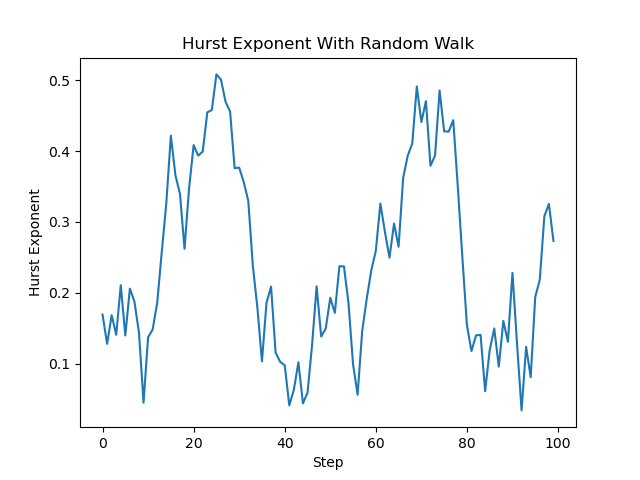

In [25]:
fig,ax = plt.subplots()
plt.plot(np.arange(len(stoch_h)),stoch_h)
plt.title('Hurst Exponent With Random Walk')
plt.xlabel('Step')
plt.ylabel('Hurst Exponent')
plt.show()

In [26]:
def gen_fbm_track_new_stoch_h(radius, ntimes, h_noise_amp, lower_h_lim = 0.001,
                              upper_h_lim = 0.999, initial_pos=(0,0,0)):
    
    #stochastic hurst exponents generated at start
    input_hurst_arr = crawling_h_uniform_dist(ntimes, h_noise_amp, lower_h_lim, upper_h_lim)
    output_hurst_arr = np.full((1,ntimes),input_hurst_arr[0])
    
    data_x, data_y, data_z = gen_fbm_track(ntimes, input_hurst_arr[0], initial_pos)
    exit_index = get_exit_index(data_x, data_y, radius)
    
    initial_pos_array = initial_pos
    
    #print(exit_check(data_x, data_y, radius))
    
    if exit_index != None:
    
        xs_exit, ys_exit, zs_exit = get_exit_coords(data_x, data_y, data_z, radius, exit_index)
        collision_xyz = get_intersection_point(xs_exit, ys_exit, zs_exit, radius)
        collision_points = collision_xyz

        data_x, data_y, data_z = track_until_collision(data_x, data_y, data_z, radius, exit_index)
        coll_indices = np.array([len(data_x)])

        collision_counter = 1

        output_hurst_arr = np.full((1,len(data_x)),input_hurst_arr[0])
        i = 0
        while len(data_x) < ntimes:

            new_initial_pos = collision_xyz
            x, y, z = gen_fbm_track(ntimes+1,  input_hurst_arr[i+1], initial_position=new_initial_pos)

            #remove collision point for now, will add back in later
            x, y, z = x[1:], y[1:], z[1:]

            new_x = np.append(data_x, x)
            new_y = np.append(data_y, y)
            new_z = np.append(data_z, z)
            
            #new_exit_index = get_exit_index(x,y,radius)
            new_exit_index = get_exit_index(new_x, new_y, radius)
            
            if new_exit_index==None:
                data_x, data_y, data_z = new_x, new_y, new_z
            else:
                new_data_x, new_data_y, new_data_z = track_until_collision(new_x, new_y, new_z, radius, new_exit_index)

                #to avoid duplicates in initial_pos_array
                if new_data_x[-1]!=data_x[-1]:

                    new_hs = np.full((1,len(new_data_x)-len(data_x)),input_hurst_arr[i])
                    output_hurst_arr = np.append(output_hurst_arr, new_hs)

                    initial_pos_array = np.vstack((initial_pos_array, new_initial_pos))
                    data_x, data_y, data_z = new_data_x, new_data_y, new_data_z

                    xs_exit, ys_exit, zs_exit = get_exit_coords(new_x, new_y, new_z, radius, new_exit_index)
                    collision_xyz = get_intersection_point(xs_exit, ys_exit, zs_exit, radius)
                    collision_points = np.vstack((collision_points, collision_xyz))
                    coll_indices = np.append(coll_indices, len(data_x))
                    collision_counter +=1

                    i += 1

        #insert collision points
        if collision_counter > 0:
            coll_xs, coll_ys, coll_zs = np.transpose(collision_points)
            data_x = np.insert(data_x, coll_indices, coll_xs)
            data_y = np.insert(data_y, coll_indices, coll_ys)
            data_z = np.insert(data_z, coll_indices, coll_zs)

        data_x, data_y, data_z = data_x[:ntimes], data_y[:ntimes], data_z[:ntimes]
        if collision_counter > 0:
            if collision_counter ==1:
                coll_xs,coll_ys,coll_zs = np.array([coll_xs]),np.array([coll_ys]),np.array([coll_zs])
            coll_xs = coll_xs[np.where(np.isin(coll_xs, data_x))]
            coll_ys = coll_ys[np.where(np.isin(coll_ys, data_y))]
            coll_zs = coll_zs[np.where(np.isin(coll_zs, data_z))]
            coll_pts = np.transpose(np.concatenate(([coll_xs], [coll_ys], [coll_zs]), axis=0))

        output_hurst_arr = output_hurst_arr[:ntimes]
    
    return data_x, data_y, data_z, initial_pos_array, output_hurst_arr

In [27]:
def plot_in_cylinder(r,nsteps,model_type,h = None,h_noise_amp = 0.1,initial_pos=None):
    """
    Function to plot fbm track in cylinder, with either model type
    """    
    fig = plt.figure()
    ax = Axes3D(fig)
    
    if initial_pos==None:
        initial_pos = get_rand_initial_pos_2(r)
    
    if model_type == "const_h":
        
        data_x, data_y, data_z, initial_pos_array,h_val = gen_fbm_track_new_const_h(r, nsteps,hurst_exp = h,
                                                                                   initial_pos=initial_pos)
        plot_random_walk_single(ax, data_x, data_y, data_z)
        plt.suptitle("Fractional Brownian Motion In Cylinder \n Hurst Exponent = {:f}; Radius = {}".format(h_val,r))
        output = (data_x, data_y, data_z, initial_pos_array,h_val)
    elif model_type == "stoch_h":
        
        data_x, data_y, data_z,initial_pos_array,h_arr = gen_fbm_track_new_stoch_h(r, nsteps, h_noise_amp,
                                                                                          lower_h_lim=0.001, upper_h_lim=0.999,
                                                                                          initial_pos=initial_pos)
        plot_random_walk_single(ax, data_x, data_y, data_z)#,c_line=h_arr,cmap_line='inferno')
        plt.suptitle("Fractional Brownian Motion In Cylinder \n Stochastic Hurst Exponent; Radius = {}".format(r))
        #fig.colorbar(label='Hurst Exponent')
        output = (data_x, data_y, data_z,initial_pos_array,h_arr)
         
    
    plot_cylinder_along_z(ax,0, 0, r, 2*np.max(np.abs(data_z)))
    try:
        ax.scatter(xs=initial_pos_array[:,0], ys=initial_pos_array[:,1], zs=initial_pos_array[:,2], color='orange')
    except :IndexError
        
    return output

<IPython.core.display.Javascript object>


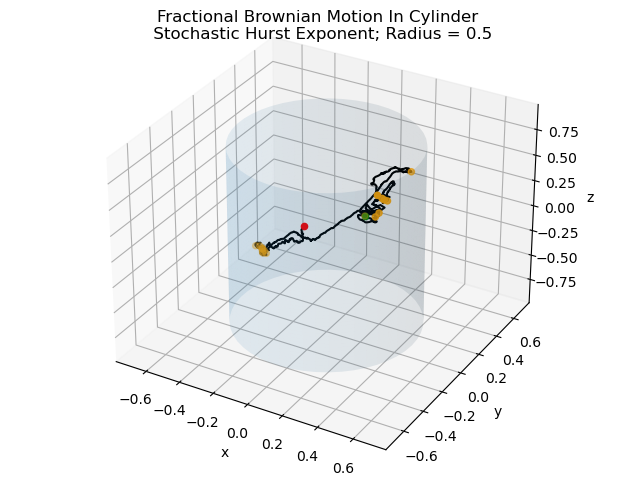

<IPython.core.display.Javascript object>


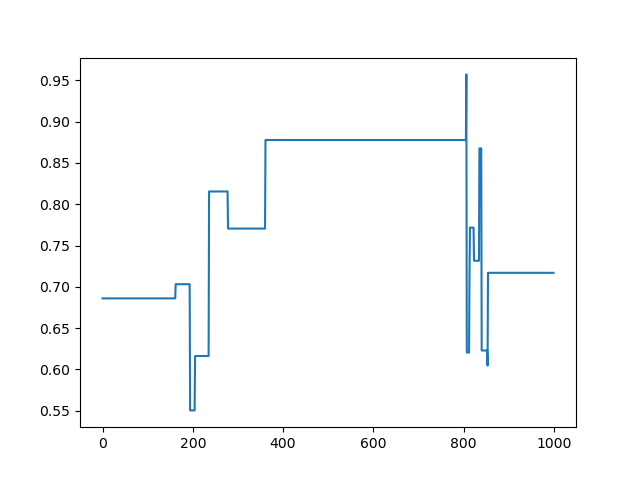

In [28]:
x,y,z,init_pos_arr,h_arr = plot_in_cylinder(0.5,1000,"stoch_h",h_noise_amp = 0.4)

fig = plt.figure()
plt.plot(h_arr)
plt.show()

In [29]:
def gen_data_different_radii(r_lower,r_upper,r_step,track_length,mc_steps,model_type,
                             h_noise_amplitude=0.1,folder_path="sim_haemocyte_pipe_data/stoch_h/"):
    """
    Function to collect mc data for fbm restricted tracks for different radii of pipe
    """
    radii = np.arange(r_lower,r_upper,r_step)
    
    for i, r in enumerate(radii):
        
        gen_mc_fbm_cylinder_csv(r,track_length,mc_steps,model_type,
                                h_noise_amplitude=h_noise_amplitude,
                                folder_path=folder_path)


In [30]:
gen_data_different_radii(0.1,1.6,0.1,200,250,"stoch_h", h_noise_amplitude=0.1,folder_path="sim_haemocyte_pipe_data/stoch_h/")

ValueError: cannot reshape array of size 110 into shape (200,1)

## H(t) work

In [ ]:
def h_sine(t):
    
    h_val = 0.5+0.4*np.sin(2*np.pi*t)
    
    return h_val

def h_step(t):
    
    print(max(t))
    
    h_val = np.piecewise(t, [t < max(t)//2, t >= max(t)//2], 
                         [lambda t: (t)//max(t), lambda t: 1-t//max(t)])

    return h_val
 
#m = mbm(n=1000, hurst=h_step, length=100, method='riemannliouville')
t = times(n=1000,length=100)

def gen_fbm_track_collisions(radius, ntimes, hurst_exp=None, initial_pos=(0,0,0)):
    """
    Function to generate full track, up to length ntimes, from a given initial position and 
    in a cylinder of specified radius. Concatenates tracks following collision to make 
    total fbm track
    """
    
    if hurst_exp == None:
        hurst_exp = np.random.uniform(0.001,0.999)
    
    data_x, data_y, data_z = gen_fbm_track(ntimes, hurst_exp, initial_pos)
    exit_index = get_exit_index(data_x, data_y, radius)
    data_x, data_y, data_z = track_until_collision(data_x, data_y, data_z, radius, exit_index)
    
    initial_pos_array = initial_pos
    
    while len(data_x) < ntimes:
        
        #subtrack_length = ntimes - len(data_x)
        new_initial_pos = (data_x[-1], data_y[-1], data_z[-1])

        x, y, z = gen_fbm_track(ntimes, hurst_exp, initial_position=new_initial_pos)
        
        new_x = np.append(data_x, x)
        new_y = np.append(data_y, y)
        new_z = np.append(data_z, z)

        new_exit_index = get_exit_index(new_x, new_y, radius)
        temp_x,temp_y,temp_z = track_until_collision(new_x, new_y, new_z, radius, new_exit_index) 
        
        #to avoid duplicates in initial_pos_array
        if temp_x[-1]!=data_x[-1]:
            
            initial_pos_array = np.vstack((initial_pos_array, new_initial_pos))
            data_x, data_y, data_z = temp_x,temp_y,temp_z

    data_x, data_y, data_z = data_x[:ntimes], data_y[:ntimes], data_z[:ntimes]

    return data_x, data_y, data_z, initial_pos_array, hurst_exp


def gen_fbm_data(nsamples, ntimes, hurst_const=None):
    """ 
    Function to produce fractional brownian motion data for neural network 
    training and testing
    Inputs: nsamples; number of samples, ntimes; number of times (= number of steps)
    Outputs: traindata; training data for NN, trainlabels; labels associated 
            with traindata
    """
    #data = np.empty((nsamples,ntimes+1,3))
    data_x = np.empty((nsamples,ntimes+1))
    data_y = np.empty((nsamples,ntimes+1))
    data_z = np.empty((nsamples,ntimes+1))
                              
    labels = np.empty((nsamples,1))
    for i in range(0,nsamples):
        if hurst_const == None:
            hurst_exp = np.random.uniform(0.,1.)
        else:
            hurst_exp = hurst_const
        fbm = FractionalBrownianMotion(hurst=hurst_exp,t=1,rng=None)
        x = fbm.sample(ntimes)
        y = fbm.sample(ntimes)
        z = fbm.sample(ntimes)
        #apply differencing and normalization on the data
        #dx = (x[1:]-x[0:-1])/(np.amax(x)-np.amin(x))
        #dy = (y[1:]-x[0:-1])/(np.amax(y)-np.amin(y))
        #dz = (z[1:]-x[0:-1])/(np.amax(z)-np.amin(z))
        #data[i,:] = np.array([x,y,z]).transpose()
        data_x[i,:] = x
        data_y[i,:] = y
        data_z[i,:] = z
        labels[i,:] = hurst_exp
        
    return data_x, data_y, data_z, labels'
    
    
def gen_fbm_track_collisions_stoch_h(radius, ntimes, h_noise_amp, lower_h_lim = 0.001,
                                     upper_h_lim = 0.999, initial_pos=(0,0,0)):
    """
    Function to simulate restricted fbm track in pipe, using stochastic hurst 
    exponents following collisions. Track length is always equal, of size ntimes.
    lower_h_lim and upper_h_lim specify absolute values of hurst to be bounded by
    h_noise_amp: amplitude of noise term for stoch_h model
    """
    #stochastic hurst exponents generated at start
    input_hurst_arr = crawling_h_uniform_dist(ntimes, h_noise_amp, lower_h_lim, upper_h_lim)
    
    data_x, data_y, data_z = gen_fbm_track(ntimes, input_hurst_arr[0], initial_pos)
    exit_index = get_exit_index(data_x, data_y, radius)
    data_x, data_y, data_z = track_until_collision(data_x, data_y, data_z, radius, exit_index)
    initial_pos_array = initial_pos
    
    output_hurst_arr = np.full((1,len(data_x)),input_hurst_arr[0])

    i = 0
    while len(data_x) < ntimes:
        
        new_initial_pos = (data_x[-1], data_y[-1], data_z[-1])
        initial_pos_array = np.vstack((initial_pos_array, new_initial_pos))
        
        x, y, z = gen_fbm_track(ntimes, input_hurst_arr[i+1], initial_position=new_initial_pos)
        
        new_x = np.append(data_x, x)
        new_y = np.append(data_y, y)
        new_z = np.append(data_z, z)
        
        #new_exit_index = get_exit_index(x, y, radius)
        new_exit_index = get_exit_index(new_x, new_y, radius)
        
        temp_x,temp_y,temp_z = track_until_collision(new_x, new_y, new_z, radius, new_exit_index)

        if temp_x[-1]!=data_x[-1]:
                               
            new_hs = np.full((1,len(temp_x)-len(data_x)),input_hurst_arr[i])
            output_hurst_arr = np.append(output_hurst_arr, new_hs)
            data_x, data_y, data_z = temp_x,temp_y,temp_z
        
            i += 1
        
    data_x, data_y, data_z = data_x[:ntimes], data_y[:ntimes], data_z[:ntimes]
    output_hurst_arr = output_hurst_arr[:ntimes]
    return data_x, data_y, data_z, initial_pos_array, output_hurst_arr


In [15]:
# def gen_fbm_track_new_stoch_h(radius, ntimes, h_noise_amp, lower_h_lim = 0.001,
#                               upper_h_lim = 0.999, initial_pos=(0,0,0)):
    
#     #stochastic hurst exponents generated at start
#     input_hurst_arr = crawling_h_uniform_dist(ntimes, h_noise_amp, lower_h_lim, upper_h_lim)
#     output_hurst_arr = np.full((1,ntimes),input_hurst_arr[0])
    
#     data_x, data_y, data_z = gen_fbm_track(ntimes, input_hurst_arr[0], initial_pos)
#     exit_index = get_exit_index(data_x, data_y, radius)
    
#     initial_pos_array = initial_pos
    
#     #print(exit_check(data_x, data_y, radius))
    
#     if exit_index != None:
    
#         xs_exit, ys_exit, zs_exit = get_exit_coords(data_x, data_y, data_z, radius, exit_index)
#         collision_xyz = get_intersection_point(xs_exit, ys_exit, zs_exit, radius)
#         collision_points = collision_xyz

#         data_x, data_y, data_z = track_until_collision(data_x, data_y, data_z, radius, exit_index)
#         coll_indices = np.array([len(data_x)])

#         collision_counter = 0

#         output_hurst_arr = np.full((1,len(data_x)),input_hurst_arr[0])
#         i = 0
#         while len(data_x) < ntimes:

#             new_initial_pos = collision_xyz
#             x, y, z = gen_fbm_track(ntimes+1,  input_hurst_arr[i+1], initial_position=new_initial_pos)

#             #remove collision point for now, will add back in later
#             x, y, z = x[1:], y[1:], z[1:]

#             new_x = np.append(data_x, x)
#             new_y = np.append(data_y, y)
#             new_z = np.append(data_z, z)
            
#             #new_exit_index = get_exit_index(x,y,radius)
#             new_exit_index = get_exit_index(new_x, new_y, radius)

#             new_data_x, new_data_y, new_data_z = track_until_collision(new_x, new_y, new_z, radius, new_exit_index)

#             #to avoid duplicates in initial_pos_array
#             if new_data_x[-1]!=data_x[-1]:

#                 new_hs = np.full((1,len(new_data_x)-len(data_x)),input_hurst_arr[i])
#                 output_hurst_arr = np.append(output_hurst_arr, new_hs)

#                 initial_pos_array = np.vstack((initial_pos_array, new_initial_pos))
#                 data_x, data_y, data_z = new_data_x, new_data_y, new_data_z

#                 xs_exit, ys_exit, zs_exit = get_exit_coords(new_x, new_y, new_z, radius, new_exit_index)
#                 collision_xyz = get_intersection_point(xs_exit, ys_exit, zs_exit, radius)
#                 collision_points = np.vstack((collision_points, collision_xyz))
#                 coll_indices = np.append(coll_indices, len(data_x))
#                 collision_counter +=1

#                 i += 1

#         #insert collision points
#         coll_xs, coll_ys, coll_zs = np.transpose(collision_points)
#         data_x = np.insert(data_x, coll_indices, coll_xs)
#         data_y = np.insert(data_y, coll_indices, coll_ys)
#         data_z = np.insert(data_z, coll_indices, coll_zs)

#         data_x, data_y, data_z = data_x[:ntimes], data_y[:ntimes], data_z[:ntimes]
#         coll_xs = coll_xs[np.where(np.isin(coll_xs, data_x))]
#         coll_ys = coll_ys[np.where(np.isin(coll_ys, data_y))]
#         coll_zs = coll_zs[np.where(np.isin(coll_zs, data_z))]
#         coll_pts = np.transpose(np.concatenate(([coll_xs], [coll_ys], [coll_zs]), axis=0))

#         output_hurst_arr = output_hurst_arr[:ntimes]
    
#     return data_x, data_y, data_z, initial_pos_array, output_hurst_arr

In [74]:
df = gen_mc_fbm_cylinder_data(0.5, 100, 100,'const_h',h_noise_amp=0.1)